# Assumed Density Filtering

## 0. Import

In [1]:
using Random
using Distributions
using Statistics
using Plots
pyplot()

Plots.PyPlotBackend()

## 1. create the data

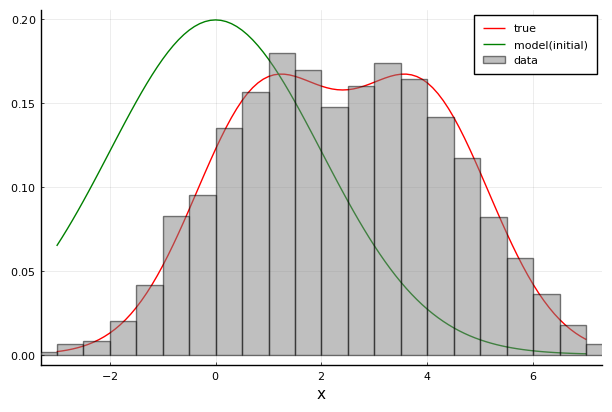

In [2]:
#true distributions
function true_F(μ₁, μ₂, σ₁_sq, σ₂_sq)
    normal1 = Normal(μ₁, σ₁_sq)
    normal2 = Normal(μ₂, σ₂_sq)
    return MixtureModel([normal1, normal2])
end

#create data
function create_data(n_data, N, true_F)
    Xs = zeros(N, n_data)
    for t in 1:n_data
        Xs[:,t] = rand(true_F, N)
    end
    return Xs
end

#create the data and plot them
n_data = 30 #there are the data D1,D1,...,D30
N = 100
μ₁ = 0.9
μ₂ = 3.9
σ₁_sq = 1.3
σ₂_sq = 1.3
mixed_normal = true_F(μ₁, μ₂, σ₁_sq, σ₂_sq)
Xs = create_data(n_data, N, mixed_normal)

#true pdf
q(x) = pdf(mixed_normal, x)

#model parameter and the pdf
σ₀_sq = 2.0
p(x, μ) = pdf(Normal(μ, σ₀_sq), x)


fig1 = plot(-3:0.1:7, q, color=:red, label="true", xlim=[-3,7], xlabel="x")
plot!(-3:0.1:7, x->p(x,0), color=:green, label="model(initial)")
plot!(Xs[:], st=:histogram, bins=30, normed=true, color=:gray, alpha=0.5, label="data")
savefig(fig1, "figs-ADF/fig1.png")

## Implementation : ADF

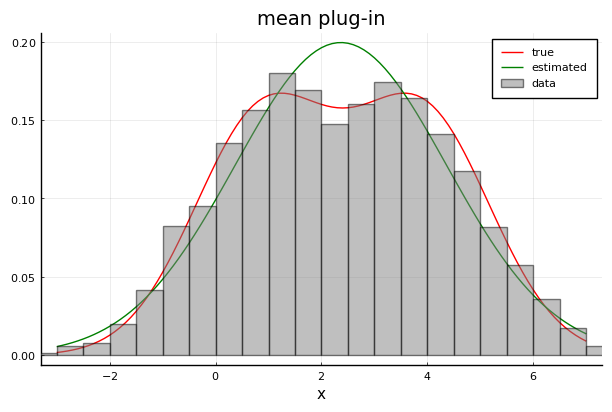

approximated posterior mean = 2.3655185402745986
approximated posterior std = 0.0006662225183211193


In [3]:
#update the mean and variance
function update_params(X, N, μ, σ_sq, σ₀_sq)
    μ_new = (σ_sq * sum(X) + σ₀_sq * μ)/(N * σ_sq + σ₀_sq)
    σ_sq_new = σ₀_sq * σ_sq / (N * σ_sq + σ₀_sq)
    return μ_new, σ_sq_new
end

#ADF
function my_ADF(Xs, σ₀_sq)
    N, n_data= size(Xs)
    μ = 0.0
    σ_sq = 1.0
    params = zeros(2, n_data+1)
    params[1,1] = μ
    params[2,1] = σ_sq
    
    for t in 1:n_data
        μ, σ_sq = update_params(Xs[:,t], N, μ, σ_sq, σ₀_sq)
        params[1,t+1] = μ
        params[2,t+1] = σ_sq
    end
    return params
end

#show the result
params = my_ADF(Xs, σ₀_sq)
println("approximated posterior mean = $(params[1,end])")
println("approximated posterior std = $(params[2,end])")

fig2 = plot(-3:0.1:7, q, color=:red, label="true", xlim=[-3,7], xlabel="x", title="mean plug-in")
plot!(-3:0.1:7, x->p(x,params[1,end]), color=:green, label="estimated")
plot!(Xs[:], st=:histogram, bins=30, normed=true, color=:gray, alpha=0.5, label="data")
savefig(fig2, "figs-ADF/fig2.png")